In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# declare a Base - this allows SQLAlchemy to automatically map the tables in the database to Python classes

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Jake\AppData\Local\Temp\ipykernel_16696\930725367.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Save references to each table
measurement_table = Base.classes.measurement
station_table = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement_table.date)).scalar()
print(most_recent_date)
type(most_recent_date)


2017-08-23


str

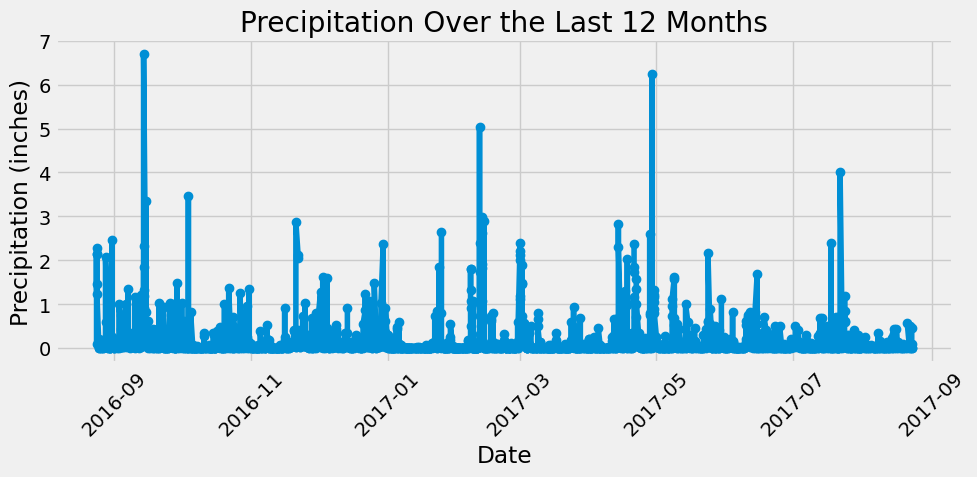

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - pd.DateOffset(months=12)

# Perform a query to retrieve the data and precipitation scores
precipitatioin_data = session.query(measurement_table.date,measurement_table.prcp).\
    filter(measurement_table.date >= str(one_year_ago)).\
    order_by(measurement_table.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitatioin_data, columns=['date','prcp'])

# Sort the dataframe by date
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['prcp'], marker='o')
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = df['prcp'].describe()
summary

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station_table.id)).scalar()
print(total_stations)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = session.query(
    measurement_table.station,
    func.count(measurement_table.station).label('observation_count')
).group_by(measurement_table.station).\
    order_by(func.count(measurement_table.station).desc()).all()

for station, observation_count in most_active:
    print(f'Station: {station}, Observation Count: {observation_count}')

Station: USC00519281, Observation Count: 2772
Station: USC00519397, Observation Count: 2724
Station: USC00513117, Observation Count: 2709
Station: USC00519523, Observation Count: 2669
Station: USC00516128, Observation Count: 2612
Station: USC00514830, Observation Count: 2202
Station: USC00511918, Observation Count: 1979
Station: USC00517948, Observation Count: 1372
Station: USC00518838, Observation Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_temp = session.query(
    func.avg(measurement_table.tobs).label('avg_temp'),
    func.min(measurement_table.tobs).label('min_temp'),
    func.max(measurement_table.tobs).label('max_temp')
).filter(measurement_table.station == 'USC00519281').one()

print(f"Min Temperature: {most_active_temp.min_temp}")
print(f"Max Temperature: {most_active_temp.max_temp}")
print(f"Avg Temperature: {most_active_temp.avg_temp}")

Min Temperature: 54.0
Max Temperature: 85.0
Avg Temperature: 71.66378066378067


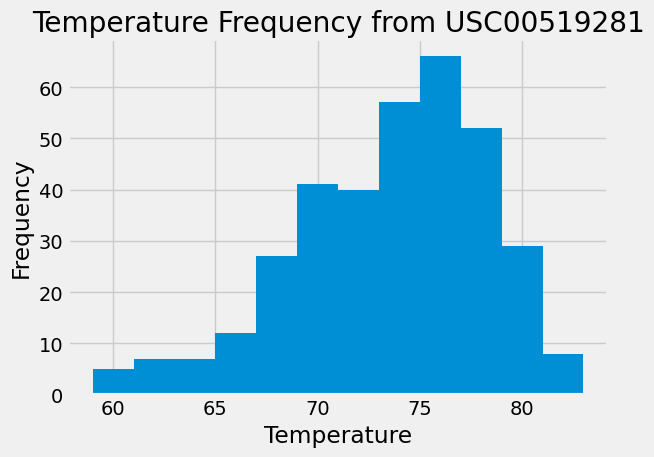

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_last_12mo = session.query(
    measurement_table.tobs.label('Temperature')
).filter(measurement_table.date >= str(one_year_ago)).\
    filter(measurement_table.station == 'USC00519281').all()

df_temp = pd.DataFrame(most_active_last_12mo, columns = ['Temperature'])
df_temp.head()

plt.hist(df_temp['Temperature'], bins=12)
plt.title('Temperature Frequency from USC00519281')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [16]:
#NOT PART OF ASSIGNMENT
# most_active_last_12mo = session.query(
#     measurement_table.tobs.label('Temperature'),
#     func.count(measurement_table.tobs).label('Frequency')
# ).filter(measurement_table.date >= str(one_year_ago)).\
#     order_by(measurement_table.tobs).\
#         group_by(measurement_table.tobs).all()

# # for Temperature, Frequency in most_active_last_12mo:
# #     print(f'Temperature: {Temperature}, Frequency: {Frequency}')

# df_temp = pd.DataFrame(most_active_last_12mo, columns = ['Temperature','Frequency'])


# plt.figure()
# plt.bar(df_temp['Temperature'], df_temp['Frequency'])
# plt.title('Temperature Frequency from USC00519281')
# plt.xlabel('Temperature')
# plt.ylabel('Frequency')
# plt.tight_layout()
# plt.show()

# Close Session

In [17]:
# Close Session
session.close()